<a href="https://colab.research.google.com/github/pteacher/galaxy_classification_spinalnet/blob/main/GalaxyClassificationSpinalNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
torch.cuda.empty_cache()
torch.no_grad()

In [ ]:
import sys
print(sys.executable)

C:\Users\user\anaconda3\python.exe


In [ ]:
#!unzip /content/drive/MyDrive/fruits/fruits-360

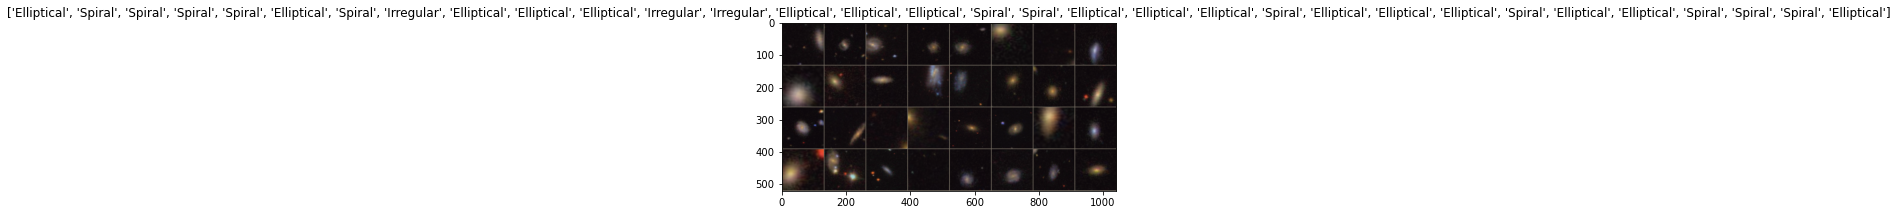

In [ ]:
plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((140,140)),
        transforms.RandomRotation(15,),
        transforms.RandomResizedCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

number_of_folders = 3
total_epochs = 25
#data_dir = './'
data_dir = 'D:\\Ala-Too Master\\Fruit Recognition\\fruits-360_dataset\\Galaxies_' + str(number_of_folders) + 'Types_DifferentTh_ManuallyCleaned'
#data_dir = 'D:\\Ala-Too Master\\Fruit Recognition\\fruits-360_dataset\\Galaxies_3Types_(few data for fast running)'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ['Training', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Test']}
class_names = image_datasets['Training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Training']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
print(device)

cuda:0


In [ ]:
#%%

# model_ft = models.vgg19_bn(pretrained=True)
# num_ftrs = model_ft.classifier[0].in_features

model_ft = models.wide_resnet101_2(pretrained=True)
num_ftrs = model_ft.fc.in_features

half_in_size = round(num_ftrs/2)
layer_width = 10 #Small for Resnet, large for VGG
Num_class= number_of_folders

# class SpinalNet_ResNet(nn.Module):
#     def __init__(self):
#         super(SpinalNet_ResNet, self).__init__()
        
#         self.fc_spinal_layer1 = nn.Sequential(
#             #nn.Dropout(p = 0.5), 
#             nn.Linear(half_in_size, layer_width),
#             #nn.BatchNorm1d(layer_width), 
#             nn.ReLU(inplace=True),)
#         self.fc_spinal_layer2 = nn.Sequential(
#             #nn.Dropout(p = 0.5), 
#             nn.Linear(half_in_size+layer_width, layer_width),
#             #nn.BatchNorm1d(layer_width), 
#             nn.ReLU(inplace=True),)
#         self.fc_spinal_layer3 = nn.Sequential(
#             #nn.Dropout(p = 0.5), 
#             nn.Linear(half_in_size+layer_width, layer_width),
#             #nn.BatchNorm1d(layer_width), 
#             nn.ReLU(inplace=True),)
#         self.fc_spinal_layer4 = nn.Sequential(
#             #nn.Dropout(p = 0.5), 
#             nn.Linear(half_in_size+layer_width, layer_width),
#             #nn.BatchNorm1d(layer_width), 
#             nn.ReLU(inplace=True),)
#         self.fc_out = nn.Sequential(
#             #nn.Dropout(p = 0.5), 
#             nn.Linear(layer_width*4, Num_class),)
#         #self.dropout = nn.Dropout(p = 0.5)
        
drop = 0.25
class SpinalNet_ResNet(nn.Module):
    def __init__(self):
        
        super(SpinalNet_ResNet, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            #nn.Dropout(p = drop), 
            nn.Linear(half_in_size, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            #nn.Dropout(p = drop), 
            nn.Linear(half_in_size+layer_width, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            #nn.Dropout(p = drop), 
            nn.Linear(half_in_size+layer_width, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            #nn.Dropout(p = drop), 
            nn.Linear(half_in_size+layer_width, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            #nn.Dropout(p = drop), 
            nn.Linear(layer_width*4, Num_class),)
        self.dropout = nn.Dropout(p = 0.25)    
    
    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x

    
class SpinalNet_VGG(nn.Module):
    def __init__(self):
        super(SpinalNet_VGG, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(layer_width*4, Num_class),)        

    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x



VGG_fc = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, Num_class)
        )


'''
Changing the fully connected layer to SpinalNet or VGG or ResNet
'''

#model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft.fc = SpinalNet_ResNet() #SpinalNet_VGG

In [ ]:
# variables for drawing learning curves

# for epoch epoch_number.append(epoch)

epoch_number = []
training_acc = []
validation_acc = []
training_loss = []
validation_loss = []

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    global confusion_matrix
    global best_confusion_matrix

    best_model_wts = copy.deepcopy(model.state_dict())
    
    best_acc = 0.0 # best even with overfitting
    best_acc2 = 0.0
    best_training_acc = 0.0 # best without overfitting
    best_val_acc = 0.0 # best without overfitting
    best_epoch_num = 0
    
    for epoch in range(num_epochs):
        print('===============================')
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #counting epochs for drawing learning curves
        epoch_number.append(epoch+1)
 
        # Each epoch has a training and validation phase
        for phase in ['Training', 'Test']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    for t, p in zip(labels.view(-1), preds.view(-1)):
                        confusion_matrix[t.long(), p.long()] += 1

                    # backward + optimize only if in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #print(confusion_matrix)
            if phase == 'Training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # collecting data for learning curves
            if phase == 'Training':
                training_acc.append(epoch_acc.item())
                training_loss.append(epoch_loss)
                
            # collecting data for learning curves    
            if phase == 'Test':
                validation_acc.append(epoch_acc.item())
                validation_loss.append(epoch_loss)
                
            # determining best accuracy without overfitting
            if phase == 'Training':
                best_training_acc = epoch_acc.item()
            else:
                best_val_acc = epoch_acc.item()
            
            # test for best_acc without overtraining
            if phase == 'Test' and epoch_acc > best_acc2 and best_training_acc > best_val_acc:                
                best_acc2 = epoch_acc
                best_epoch_num = epoch
                print()
                print("Training Loss: **** Acc: " + str(best_training_acc))
                print("Test Loss: **** Acc: " + str(best_val_acc)) 
                
            
#           #just to manually identify if the best_confusion_matrix was found correct
#             if phase == 'Test':
#                 print(confusion_matrix[0][0], confusion_matrix[0][1])


            # deep copy the model
            if phase == 'Test' and epoch_acc > best_acc:
                best_confusion_matrix = confusion_matrix
                confusion_matrix = np.zeros((Num_class, Num_class))
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                time_elapsed = time.time() - since
                print('Time from Start {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))        
            
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val overfit Acc: {:4f}'.format(best_acc))
    print('Best val         Acc: {:4f}'.format(best_acc2))
    print('Best epoch: ' + str(best_epoch_num))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# our trained model
# model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

In [ ]:
confusion_matrix = np.zeros((Num_class, Num_class))
best_confusion_matrix = np.zeros((Num_class, Num_class))
# Observe that all parameters are being optimized
# try other opimizations. For example ADAM
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# try to change gamma from 0.1 up to 0.00001. Or 0.2. Also change steps not 7 maybe 10
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.3)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=total_epochs)

#saving model with which u can predict any other image
#torch.save(model_ft.state_dict(), 'gal.pth')

Epoch 0/24
Training Loss: 0.5374 Acc: 0.7806
Test Loss: 0.5638 Acc: 0.7963
Time from Start 1m 7s

Epoch 1/24


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import time
import os
import copy
from sklearn.metrics import confusion_matrix

import random

In [ ]:
# Confusion Matrix of Dipu Kabir

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

y_pred = [] #x
y_true = [] #y
output_all =[]

# iterate over test data
for inputs, labels in dataloaders['Training']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    output = model_ft(inputs) # Feed Network
    output_all.extend(output.data.cpu().numpy())

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
# classes  = image_datasets['Training'].classes
# labels = image_datasets['Training'].classes

classes = labels = image_datasets['Training'].classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

sum_by_rows = np.array(np.sum(cf_matrix,axis=1).tolist())

cf_matrix_normalized = cf_matrix / sum_by_rows[:,None]


df_cm = pd.DataFrame(cf_matrix_normalized, index = [i for i in classes],
                     columns = [i for i in classes])


plt.figure(figsize=(15,10), dpi=300)

#plt.figure(figsize = (4,1),dpi=300)
plt.rcParams['font.size'] = '12'
#=====
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2', cmap='Blues') #fmt=".0f",

heatmap.yaxis.set_ticklabels(labels, rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(labels, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted')
#======
with open('train.npy', 'wb') as f:
    np.save(f, output_all)
    np.save(f, y_true)
#with open('test.npy', 'rb') as f:
#    a = np.load(f)
#    b = np.load(f)
#print(a, b)
plt.savefig('Normalized confusion matrix.png', dpi=300, bbox_inches='tight')

In [ ]:
# # how to divide every row of a matrix by elements of list

# matrix = np.array([[2,2,2],[6,6,6],[12,12,12]])
# vector = np.array([2,3,4])

# matrix = matrix / vector[:,None]
# matrix

In [ ]:
import matplotlib.pyplot as plt

# makes the plot wider
plt.figure(figsize=(12,6))

# line 1 points
x1 = epoch_number
y1 = validation_acc
# plotting the line 1 points
plt.plot(x1, y1, label = "Validation Accuracy")
 
# line 2 points
x2 = epoch_number
y2 = training_acc
# plotting the line 2 points
plt.plot(x2, y2, label = "Training Accuracy")
 
# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('Accuracy')
 
# giving a title to my graph
plt.title('Training & Validation Accuracy')

# show a legend on the plot
plt.legend()



# function to show the plot
plt.savefig('Training & Validation Accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# line 1 points
x1 = epoch_number
y1 = validation_loss
# plotting the line 1 points
plt.plot(x1, y1, label = "Validation Loss")
 
# line 2 points
x2 = epoch_number
y2 = training_loss
# plotting the line 2 points
plt.plot(x2, y2, label = "Training Loss")
 
# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('Loss')
 
# giving a title to my graph
plt.title('Training & Validation Loss')

# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.savefig('Training & Validation Loss.png', dpi=300, bbox_inches='tight')
plt.show()